In [129]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/2Spin`


In [130]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, LaTeXStrings, JLD2, Statistics, Interpolations
import PyPlot as plt
using PyCall, Conda

In [48]:
function gen_J(N, K, J_params; rng=Xoshiro(1234))
    J = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64)
    @inbounds @fastmath for i in 1:N
        @inbounds @fastmath for j in i+1:N
            if J[i, j] ≠ 0
                Jval = J_params[1]/sqrt(K) * (rand(rng) < 0.5 ? 1 : -1)
                J[i, j] = Jval
                J[j, i] = Jval
            end
        end
    end
    dropzeros!(J)
    return J
end

"""
    running_logavg(x, y; halfdecade=0.1)

Compute a running (moving) average of `y` against `x` in log–log space.

# Arguments
- `x::AbstractVector{<:Real}`:  abscissae (must be > 0)
- `y::AbstractVector{<:Real}`:  ordinates (must be > 0)
- `halfdecade::Real=0.1`: half–width of the smoothing window in decades of `x`
    (i.e. window spans ± `halfdecade` in `log10(x)`)

# Returns
- `(xs, ys_smooth)`, where
  - `xs` is the sorted `x`,
  - `ys_smooth[i]` = 10^( mean{ log10(y[j]) : |log10(x[j]) - log10(xs[i])| ≤ halfdecade } ).

Points with `x≤0` or `y≤0` are filtered out automatically.
"""
function running_logavg(x::AbstractVector, y::AbstractVector; halfdecade::Real=0.1)
    # filter positives only
    mask = (x .> 0) .& (y .> 0)
    xpos = x[mask]; ypos = y[mask]

    # sort by x
    idx = sortperm(xpos)
    xs = xpos[idx]
    ys = ypos[idx]

    # log-transforms
    lx = log10.(xs)
    ly = log10.(ys)

    N = length(xs)
    ys_smooth = similar(ys)
    # sliding window in log-space
    for i in 1:N
        # find neighbors within halfdecade
        Δ = abs.(lx .- lx[i])
        local_mask = Δ .<= halfdecade
        # arithmetic mean in log-space
        μ = mean(ly[local_mask])
        ys_smooth[i] = 10.0^μ
    end

    return xs, ys_smooth
end

running_logavg

# Check RS assumption

In [167]:
#############
# Load data #
#############

# Load MC data
N, K = 1000, 5
J, D = 1.0, 0.3
tmax = 2e1
nsim = 10000
dt = 1e-2
dt_save = 1e-1
x0_min, x0_max = -3.0, 3.0

ilist = [1, 2, 1000]
#Corr_Bim_N-1000_K-10_J-1.0_D-0.3_tmax-200.0_dtMC-0.1_dtsave-1.0_nsim-5000_x0min--3.0_x0max-3.0.jld2
filename = "data/RRG/Corr_Bim_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, Cs, tidxs= load(filename, "tsave", "autocorrs", "tidxs");

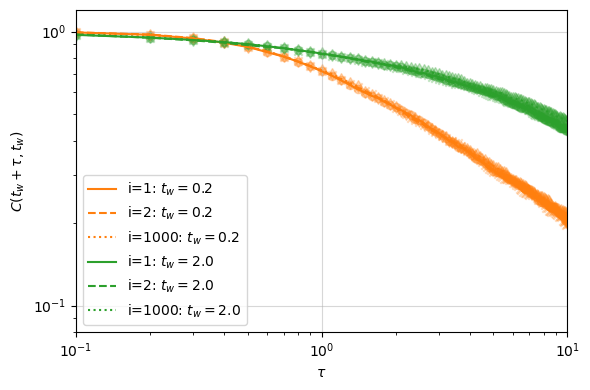

In [175]:
# Plot correlations for the two nodes at different waiting times
tws = collect(10 .^ range(log10(2e-1), stop=log10(2), length=2))

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

markers = ["o", "x", "d"]
lstyles = ["-", "--", ":"]
# Iterate over the waiting times
for (i, tw) in enumerate(tws)
    for (idx, inode) in enumerate(ilist)
        tvec = tsave[tidxs[idx]]
        C_mc = Cs[idx]
        # Get the corresponding indices (your existing code)
        tw_idx = argmin(abs.(tvec .- tw))
        tw = tvec[tw_idx]
        # Get unique indices for log-spaced sampling (your existing code)
        imin, imax = tw_idx, length(tvec)
        logmin, logmax = log10(imin), log10(imax)
        indices = round.(Int, exp10.(range(logmin, logmax, length=80)))
        unique_indices = imin:imax#unique(indices[indices .>= imin .&& indices .<= imax])
        # Plot the first node's correlation
        ax.scatter(tvec[unique_indices] .- tw, C_mc[unique_indices, tw_idx] ./ C_mc[tw_idx, tw_idx], color="C$i", alpha=0.3, marker=markers[idx])
        # smooth with a ±0.2‐decade window
        xs, ys_s = running_logavg(tvec[tw_idx:end] .- tw, C_mc[tw_idx:end, tw_idx] ./ C_mc[tw_idx, tw_idx]; halfdecade=.01)
        ax.plot(xs, ys_s, color="C$i", label="i=$inode: "*L"t_w=" *"$(round(tw, digits=3))", ls=lstyles[idx])
    end
end

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-1, 1e1)
ax.set_ylim(8e-2, 1.2)
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=.5)
ax.legend()

plt.display(fig)

# Save the figure
plt.savefig("Check_RS_RRG_N$(N)_K$(K)_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_RS_RRG_N$(N)_K$(K)_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

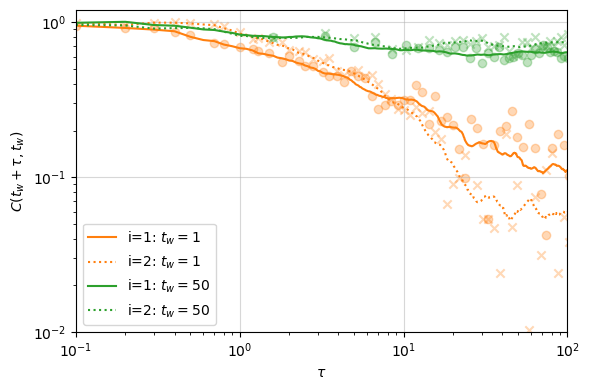

In [ ]:
# Plot correlations for the two nodes at different waiting times
tws = collect(10 .^ range(log10(1.0), stop=log10(50), length=2))

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

# Iterate over the waiting times
for (i, (tw1, tw2)) in enumerate(Iterators.zip(tws_real1, tws_real2))
    
    # Get the corresponding indices (your existing code)
    tw_idx1 = argmin(abs.(tvec1 .- tw1))
    tw1 = tvec1[tw_idx1]
    # Get unique indices for log-spaced sampling (your existing code)
    imin1, imax1 = tw_idx1, length(tvec1)
    logmin1, logmax1 = log10(imin1), log10(imax1)
    indices1 = round.(Int, exp10.(range(logmin1, logmax1, length=80)))
    unique_indices1 = unique(indices1[indices1 .>= imin1 .&& indices1 .<= imax1])
    # Plot the first node's correlation
    ax.scatter(tvec1[unique_indices1] .- tw1, C_mc1[unique_indices1, tw_idx1] ./ C_mc1[tw_idxs1[i], tw_idxs1[i]], color="C$i", alpha=0.3, marker="o")
    # smooth with a ±0.2‐decade window
    xs, ys_s = running_logavg(tvec1[tw_idxs1[i]:end] .- tw1, C_mc1[tw_idxs1[i]:end, tw_idxs1[i]] ./ C_mc1[tw_idxs1[i], tw_idxs1[i]]; halfdecade=.15)
    ax.plot(xs, ys_s, color="C$i", label="i=1: "*L"t_w=" *"$(round(Int,tw1))", ls="-")


    # Get the corresponding indices (your existing code)
    tw_idx2 = argmin(abs.(tvec2 .- tw2))
    tw2 = tvec2[tw_idx2]
    # Get unique indices for log-spaced sampling (your existing code)
    imin2, imax2 = tw_idx2, length(tvec2)
    logmin2, logmax2 = log10(imin2), log10(imax2)
    indices2 = round.(Int, exp10.(range(logmin2, logmax2, length=80)))
    unique_indices2 = unique(indices2[indices2 .>= imin2 .&& indices2 .<= imax2])
    # Plot the first node's correlation
    ax.scatter(tvec2[unique_indices2] .- tw2, C_mc2[unique_indices2, tw_idx2] ./ C_mc2[tw_idxs2[i], tw_idxs2[i]], color="C$i", alpha=0.3, marker="x")
    # smooth with a ±0.2‐decade window
    xs, ys_s = running_logavg(tvec2[tw_idxs2[i]:end] .- tw2, C_mc2[tw_idxs2[i]:end, tw_idxs2[i]] ./ C_mc2[tw_idxs2[i], tw_idxs2[i]]; halfdecade=.15)
    ax.plot(xs, ys_s, color="C$i", label="i=2: "*L"t_w=" *"$(round(Int,tw2))", ls=":")
    
end

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(1e-1, 1e2)
ax.set_ylim(1e-2, 1.2)
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=.5)
ax.legend()

plt.display(fig)

# Save the figure
plt.savefig("Check_RS_RRG_N$(N)_K$(K)_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_RS_RRG_N$(N)_K$(K)_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

# Check aging on Ferro

In [206]:
N, K = 1000, 4
J, D = 1.0, 0.3
tmax = 2e2
dt = 1e-2
dt_save = 1.0
x0_min, x0_max = -1.0, 1.0

nsim = 500
#Corr_Bim_N-1000_K-4_J-1.0_D-0.3_tmax-200.0_dtMC-0.01_dtsave-1.0_nsim-1000_x0min--3.0_x0max-3.0.jld2
filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0], [1.0000000000000089 0.0 … 0.0 0.0; 0.8697446223397758 1.4323872106363242 … 0.0 0.0; … ; 0.01952780487665739 0.05108996831429135 … 1.3009921117838175 0.0; 0.019831334003896466 0.05088970104999775 … 1.1052111576733532 1.3015491732628326])

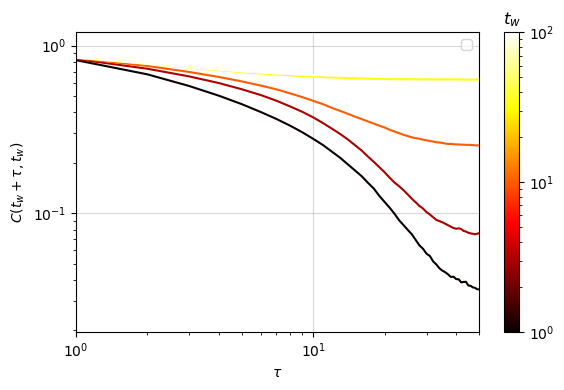

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [209]:
# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1.0), stop=log10(1e2), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e0, 5e1)
ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.legend()

plt.display(fig)
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)


In [210]:
N, K = 1000, 10
J, D = 1.0, 0.3
tmax = 2e2
dt = 1e-2
dt_save = 1.0
x0_min, x0_max = -1.0, 1.0

nsim = 500
#Corr_Bim_N-1000_K-4_J-1.0_D-0.3_tmax-200.0_dtMC-0.01_dtsave-1.0_nsim-1000_x0min--3.0_x0max-3.0.jld2
filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 197.0, 198.0, 199.0, 200.0], [1.000000000000039 0.0 … 0.0 0.0; 0.9388538506976033 1.5183290058528187 … 0.0 0.0; … ; 0.020991482716006107 0.06548011439707155 … 1.301208255990642 0.0; 0.021113806034461797 0.06586927553421436 … 1.1076194087611244 1.3015980237156475])

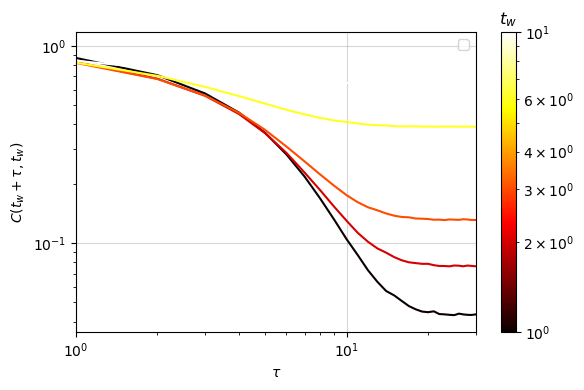

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [215]:
# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1.0), stop=log10(1e1), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e0, 3e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.legend()

plt.display(fig)
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

In [216]:
N, K = 1000, 100
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-1
x0_min, x0_max = -1.0, 1.0

nsim = 500
#Corr_Bim_N-1000_K-4_J-1.0_D-0.3_tmax-200.0_dtMC-0.01_dtsave-1.0_nsim-1000_x0min--3.0_x0max-3.0.jld2
filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0], [0.9999999999999767 0.0 … 0.0 0.0; 1.0000689858689173 1.0599784365359086 … 0.0 0.0; … ; 0.020044250351424472 0.02340258023166309 … 1.301467396227867 0.0; 0.020470102345261722 0.02388451630470656 … 1.272689232395261 1.3014363812512049])

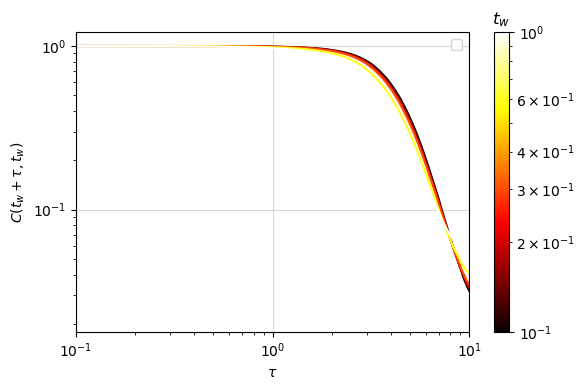

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [221]:
# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e0), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e-1, 1e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.legend()

plt.display(fig)
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

In [223]:
N, K = 1000, 500
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-1
x0_min, x0_max = -1.0, 1.0

nsim = 500
filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0], [0.9999999999999611 0.0 … 0.0 0.0; 0.999908193005386 1.0599741631305046 … 0.0 0.0; … ; 0.02376378539062692 0.02813842959168789 … 1.3015550836586356 0.0; 0.024335130952190028 0.028849614144168603 … 1.2727088400282403 1.3013347453190138])

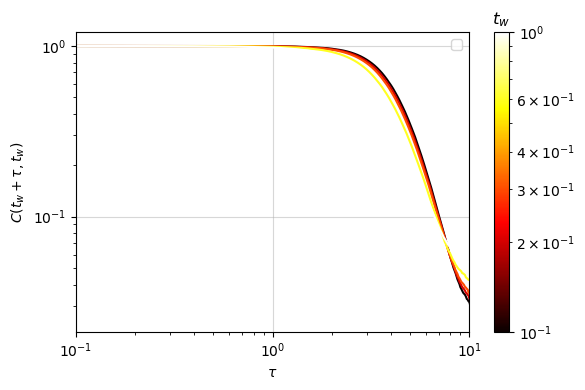

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [226]:
# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e0), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e-1, 1e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.legend()

plt.display(fig)
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

In [227]:
N = 500
K = N - 1
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-2
x0_min, x0_max = -1.0, 1.0
nsim = 500
filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.0], [1.000000000000007 0.0 … 0.0 0.0; 1.0000000000000016 1.0059884249025546 … 0.0 0.0; … ; 0.029230007761969615 0.029739501173254104 … 1.3007560486659404 0.0; 0.029207212777207208 0.029700958694523952 … 1.2977040056803735 1.3006605636165955])

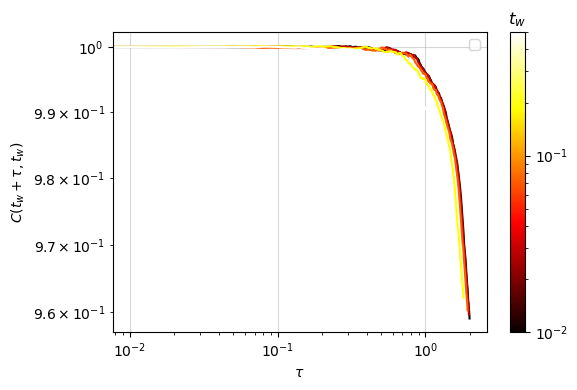

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e0), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
#ax.set_xlim(1e-1, 4e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.legend()

plt.display(fig)

plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_agingFerro_RRG_N$(N)_K$(K)_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

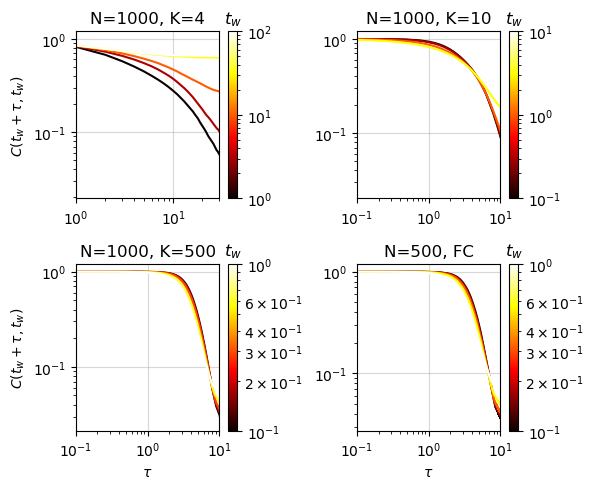

In [260]:
# Plot all together
fig, axs = plt.subplots(2, 2, figsize=(6, 5), tight_layout=true)

###############
# N=1000, K=4 #
###############
N, K = 1000, 4
J, D = 1.0, 0.3
tmax = 2e2
dt = 1e-2
dt_save = 1.0
x0_min, x0_max = -1.0, 1.0
nsim = 500

filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1.0), stop=log10(1e2), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

ax = axs[1,1]

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e0, 3e1)
ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(L"C(t_w + \tau, t_w)")
ax.grid(alpha=0.5)
ax.set_title("N=1000, K=4")


################
# N=1000, K=10 #
################
N, K = 1000, 10
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-1
x0_min, x0_max = -1.0, 1.0
nsim = 500

filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e1), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

ax = axs[1, 2]

for (i, tw) in enumerate(tws[1:end-1])
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e-1,1e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.5)
ax.set_title("N=1000, K=10")


#################
# N=1000, K=100 #
#################
N, K = 1000, 500
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-1
x0_min, x0_max = -1.0, 1.0
nsim = 500

filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e0), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

ax = axs[2, 1]

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e-1,1e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.5)
ax.set_title("N=1000, K=500")
ax.set_xlabel(L"\tau")
ax.set_ylabel(L"C(t_w + \tau, t_w)")


#############
# N=500, FC #
#############
N = 500
K = N - 1
J, D = 1.0, 0.3
tmax = 2e1
dt = 1e-2
dt_save = 1e-2
x0_min, x0_max = -1.0, 1.0
nsim = 500

filename = "data/RRG/Corr_Ferro_N-$(N)_K-$(K)_J-$(J)_D-$(D)_tmax-$(tmax)_dtMC-$(dt)_dtsave-$(dt_save)_nsim-$(nsim)_x0min-$(x0_min)_x0max-$(x0_max).jld2"
tsave, C = load(filename, "tsave", "autocorr_traj")

# Define tws (logarithmically spaced waiting times)
tws = collect(10 .^ range(log10(1e-1), stop=log10(1e0), length=5))

# Initialize colormap with proper normalization based on tws
my_cmap = plt.cm.hot
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(tws), vmax=maximum(tws))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work

ax = axs[2, 2]

for (i, tw) in enumerate(tws)
    # Get the corresponding indices (your existing code)
    tw_idx = argmin(abs.(tsave .- tw))
    tw = tsave[tw_idx]
    # Plot the correlation
    ax.plot(tsave[tw_idx:end] .- tw, C[tw_idx:end, tw_idx] ./ C[tw_idx, tw_idx], color=my_cmap(norm(tw)))
end

# Add colorbar with correct tw mapping
clb = plt.colorbar(sm, ax=ax)
clb.ax.set_title(L"t_w")

# Set scales and labels (your existing code)
ax.set_xlim(1e-1, 1e1)
#ax.set_ylim(C[argmin(abs.(tsave .- 1e2)), 1], 1.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(L"\tau")
ax.grid(alpha=0.5)
ax.set_title("N=500, FC")

plt.display(fig)
plt.savefig("Check_agingFerro_RRG_J$(J)_D$(D).pdf", bbox_inches="tight")
plt.savefig("Check_agingFerro_RRG_J$(J)_D$(D).png", dpi=300, bbox_inches="tight")
plt.close(fig)

# 